In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress

In [6]:

#Pull Data from LSV File Path
file_path = 'b/180.lvm'
df = pd.read_csv(file_path, sep='\t', skiprows=23, header=None)

#Time Vector
t = df.iloc[:, 0].to_numpy()[:]
baseline = np.zeros((5, len(t)))
#Voltage Information
baseline[0] = df.iloc[:, 2].to_numpy()[:]

file_path = 'b/135.lvm'
df = pd.read_csv(file_path, sep='\t', skiprows=23, header=None)
baseline[1] = df.iloc[:, 2].to_numpy()[:]

file_path = 'b/90.lvm'
df = pd.read_csv(file_path, sep='\t', skiprows=23, header=None)
baseline[2] = df.iloc[:, 2].to_numpy()

file_path = 'b/45.lvm'
df = pd.read_csv(file_path, sep='\t', skiprows=23, header=None)
baseline[3] = df.iloc[:, 2].to_numpy()

file_path = 'b/0.lvm'
df = pd.read_csv(file_path, sep='\t', skiprows=23, header=None)
baseline[4] = df.iloc[:, 2].to_numpy()

#dt and FS (time step and sampling frequency if needed, we used a FS of 1000 Hz I believe)
dt = t[1]-t[0]
FS = 1/dt

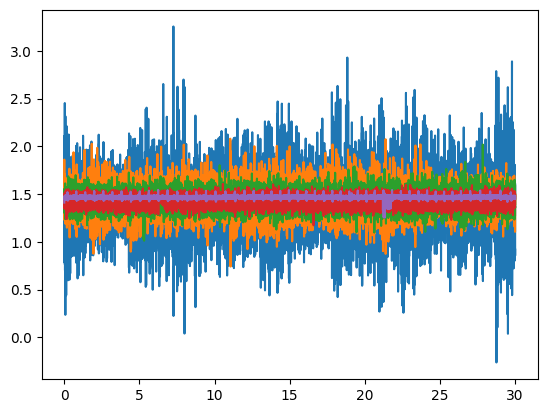

In [7]:
for i in baseline[::-1]:
    plt.plot(t, i)

In [8]:
chunk_size_ms = 100
total_average_duration_ms = 400
num_average_over = int(total_average_duration_ms/chunk_size_ms)
def acq_Sim(array, acq_time_ms):
    chunk_size = int(acq_time_ms/dt/1000)
    """Split array into chunks of specified size."""
    num_chunks = len(array) // chunk_size + (1 if len(array) % chunk_size else 0)
    return [array[i*chunk_size:(i+1)*chunk_size] for i in range(num_chunks)]

def process_acq_pkpk(array_of_arrays):
    return np.array([np.max(subarray)-np.min(subarray) for subarray in array_of_arrays])

def running_avg(arr, avg_num):
    result = np.zeros(len(arr))

    for i in range(len(arr)):
        # For the first avg_num values, adjust the averaging to include up to the current index i
        if i < avg_num:
            result[i] = np.mean(arr[0:i+1])
        else:
            # Calculate the average including the value at index i and the previous avg_num values
            result[i] = np.mean(arr[i-avg_num+1:i+1])

    return result

baseline_pkpk_processed = process_acq_pkpk(acq_Sim(baseline[0], chunk_size_ms))

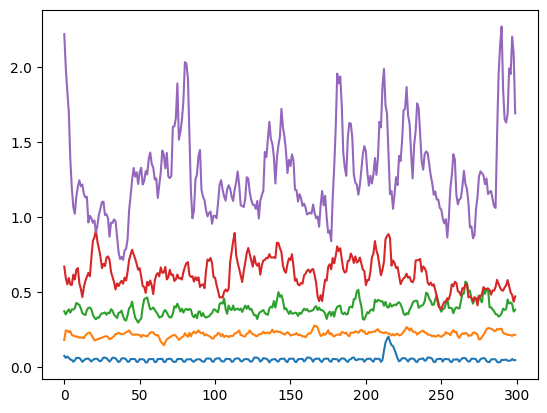

In [9]:
for i in baseline:
    plt.plot(running_avg(process_acq_pkpk(acq_Sim(i, chunk_size_ms)), num_average_over))


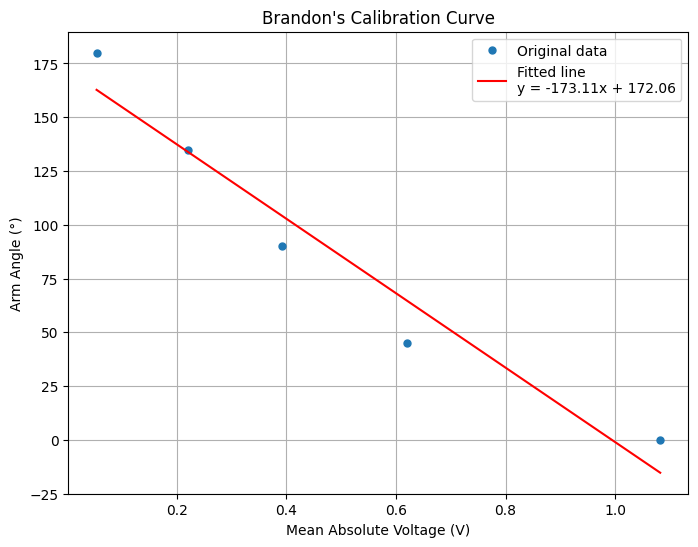

In [10]:
angles = np.arange(180, -1, -45)
average = np.zeros(len(baseline))
for i, arr in enumerate(baseline):
    average[i] = np.mean(process_acq_pkpk(acq_Sim(arr, chunk_size_ms)))
average[4] = average[4]-0.2
slope, intercept, r_value, p_value, std_err = linregress(average, angles)

# Calculate the regression line values
regression_line = slope * average + intercept

# Plot the original data and the regression line
plt.figure(figsize=(8, 6))
plt.plot(average, angles, 'o', label='Original data', markersize=5)  # Original data points
plt.plot(average, regression_line, 'r', label='Fitted line')  # Regression line
plt.grid()
plt.xlabel("Mean Absolute Voltage (V)")
plt.ylabel("Arm Angle (°)")
plt.title("Brandon's Calibration Curve")
equation_text = f"y = {slope:.2f}x + {intercept:.2f}"

plt.legend(['Original data', 'Fitted line\n' + equation_text])


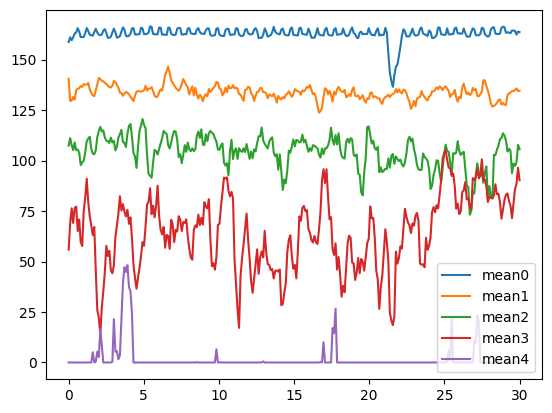

In [11]:
baseline_processed = np.zeros((len(baseline),len(running_avg(process_acq_pkpk(acq_Sim(baseline[0], chunk_size_ms)), num_average_over))))
for i, arr in enumerate(baseline):
    baseline_processed[i] = np.clip(slope*running_avg(process_acq_pkpk(acq_Sim(arr, chunk_size_ms)), num_average_over)+intercept, 0, 180)

t_modified = np.linspace(0, 30, len(baseline_processed[0]), endpoint = 'true')


for i in range(len(baseline)):
    
    plt.plot(t_modified, baseline_processed[i], label = 'mean' + str(i))

    plt.legend()

In [12]:
file_path = 'b/testb.lvm'
df = pd.read_csv(file_path, sep='\t', skiprows=23, header=None)

#Time Vector
t2 = df.iloc[:, 0].to_numpy()
#Voltage Information
voltage = df.iloc[:, 2].to_numpy()
output = df.iloc[:, 1].to_numpy()
LPFOutput = np.convolve(output, np.zeros(40) + 1/40, mode = 'same')

calib_error = 25
rawOutput = ((LPFOutput*60)-calib_error)*180/(180-calib_error)



emgFormula = np.clip(slope*running_avg(process_acq_pkpk(acq_Sim(voltage, chunk_size_ms)), num_average_over)+intercept, 0, 180)
tCustom = np.linspace(0, 60, len(emgFormula))



In [13]:
groundTruth = [180, 180, 180, 160, 120, 90, 40, 20, 10, 10, 30, 60, 70, 80, 90, 130, 160, 170, 180, 140, 100, 100, 90, 90, 90, 90, 90, 70, 40, 40, 20, 0, 0, 10, 20, 40, 50, 60, 90, 90, 90, 100, 120, 130, 140, 180, 160, 120, 90, 40, 10, 30, 90, 120, 160, 180, 170, 140, 90, 40, 0, 20, 40, 100, 140, 160, 180, 180, 150, 110, 90, 80, 70, 60, 50, 40, 0, 20, 30, 40, 30, 40, 60, 80, 90, 120, 150, 160, 160, 170, 180, 180, 180, 0, 90, 30, 0, 180, 150, 90, 20, 90, 170, 180, 180, 130, 90, 90, 90, 90, 90, 40, 20, 70, 130, 140, 150, 150, 160, 180, 180]

print(len(groundTruth))
tGroundTruth = np.linspace(0, 60, len(groundTruth))

121


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


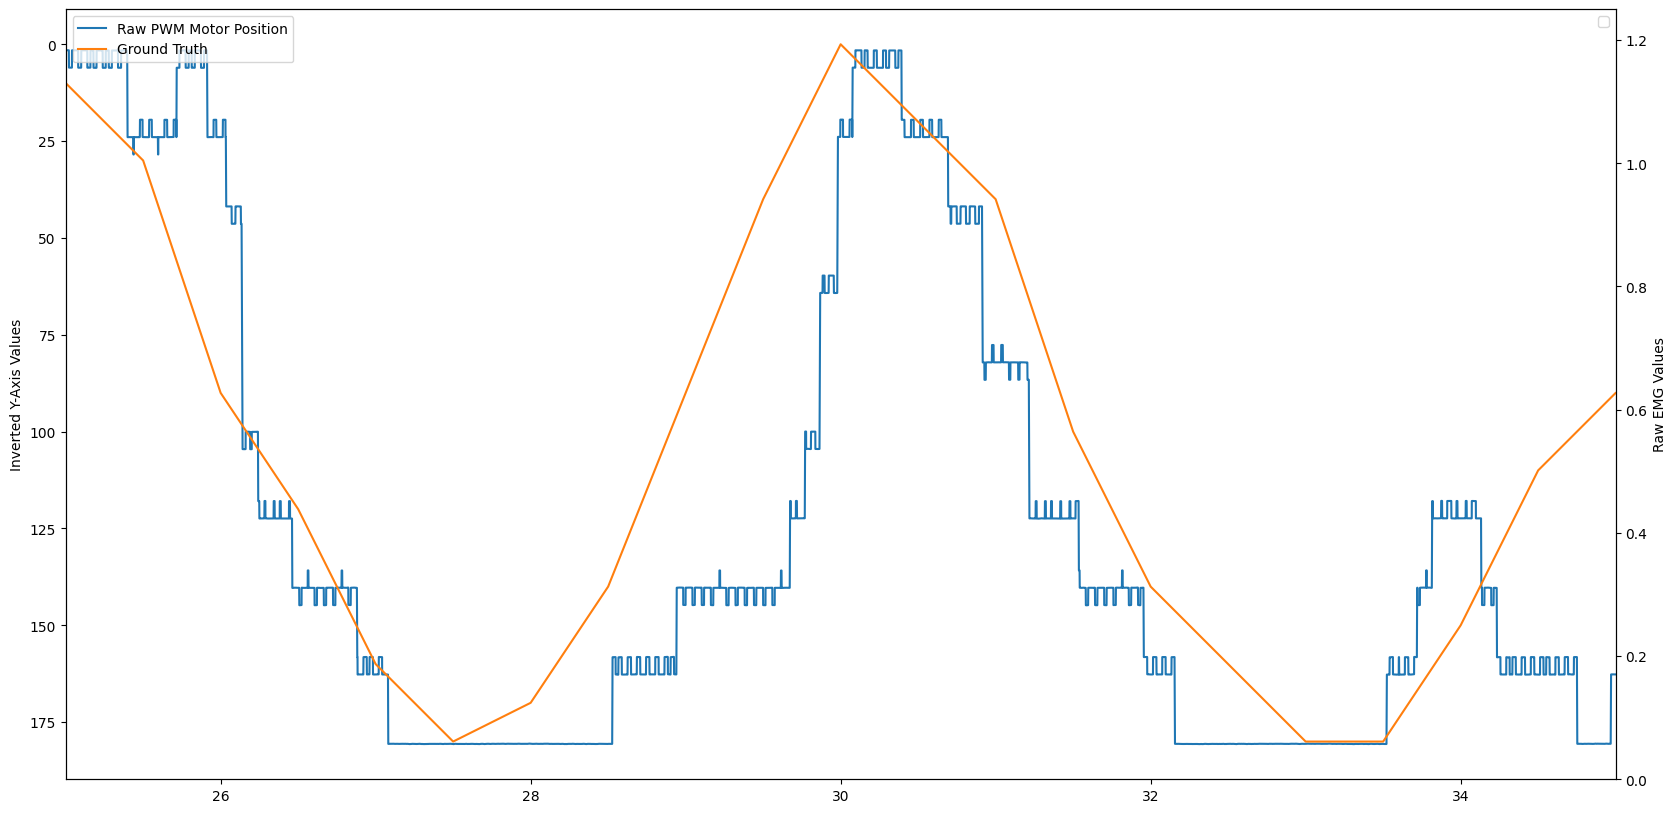

In [14]:
plt.figure(figsize=(20, 10))

# Primary Y-axis
ax1 = plt.gca()  # Get current axis
ax1.plot(t2, rawOutput, label='Raw PWM Motor Position')
#ax1.plot(tCustom, emgFormula, label='Python Predicted EMG')
ax1.plot(tGroundTruth, groundTruth, label = 'Ground Truth')
ax1.set_ylabel('Inverted Y-Axis Values')
ax1.invert_yaxis()  # Inverting the primary y-axis
ax1.legend(loc='upper left')

# Secondary Y-axis
ax2 = ax1.twinx()  # Create a twin of the primary y-axis
#ax2.plot(t2, np.abs(voltage-1.5), alpha=0.5, label='Raw EMG Data', color='r')  # Plot on the secondary y-axis
ax2.set_ylabel('Raw EMG Values')
plt.ylim(0, 1.25)
plt.xlim(25, 35)
ax2.legend(loc='upper right')

plt.show()

120000 121


(0.0, 10.0)

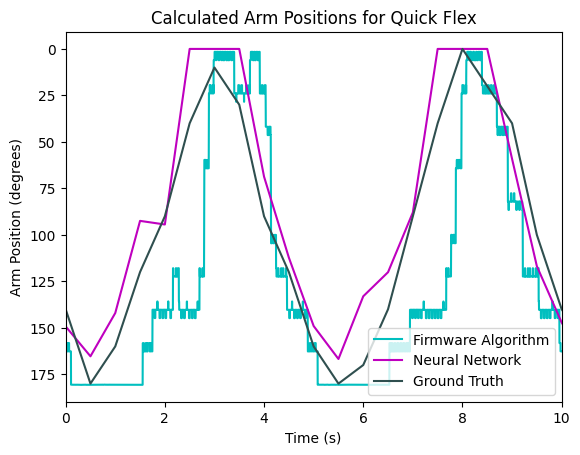

In [21]:
import pickle as pkl
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


pickle_file = '/Users/dcunhrya/Documents/MEDesign/EMG_nn/blu_nn.pkl'
with open(pickle_file, 'rb') as f:
    blu_nn = pkl.load(f)
nn_data = blu_nn['nn_predict']
nn_data = np.append(nn_data, nn_data[-1])
# r2 = r2_score(nn_data[21:41], groundTruth[21:41])
# print(r2)
# r2_score = r2_score(rawOutput[21000:41000], groundTruth[21:41])

# print(r2_score)

print(len(rawOutput), len(groundTruth))

# Primary Y-axis
ax1 = plt.gca()  # Get current axis
ax1.plot(t2 - 22, rawOutput, 'c', label='Firmware Algorithm')
ax1.plot(tGroundTruth - 22, nn_data, 'm', label='Neural Network')
#ax1.plot(tCustom, emgFormula, label='Python Predicted EMG')
ax1.plot(tGroundTruth - 22, groundTruth, color='darkslategray', label = 'Ground Truth')
ax1.set_title('Calculated Arm Positions for Quick Flex')
ax1.set_ylabel('Arm Position (degrees)')
ax1.set_xlabel('Time (s)')
ax1.invert_yaxis()  # Inverting the primary y-axis
ax1.legend(loc='lower right')
plt.xlim(0, 10)

# Secondary Y-axis
# ax2 = ax1.twinx()  # Create a twin of the primary y-axis
# #ax2.plot(t2, np.abs(voltage-1.5), alpha=0.5, label='Raw EMG Data', color='r')  # Plot on the secondary y-axis
# ax2.set_ylabel('Raw EMG Values')
# plt.ylim(0, 1.25)
# ax2.legend(loc='upper right')

(0.0, 12.0)

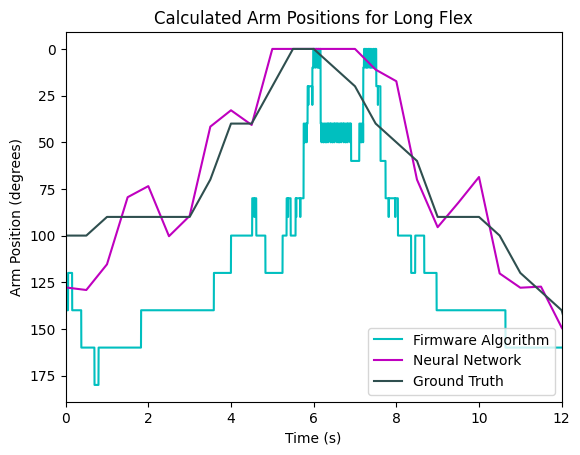

In [16]:
import pickle as pkl
pickle_file = '/Users/dcunhrya/Documents/MEDesign/EMG_nn/blu_nn.pkl'
with open(pickle_file, 'rb') as f:
    blu_nn = pkl.load(f)
nn_data = blu_nn['nn_predict']
nn_data = np.append(nn_data, nn_data[-1])

def round_to_nearest_ten(degrees):
    return 10 * round(degrees / 10)
rounded_raw = [round_to_nearest_ten(angle) for angle in rawOutput]

# Primary Y-axis
ax1 = plt.gca()  # Get current axis
ax1.plot(t2 - 10, rounded_raw, 'c', label='Firmware Algorithm')
ax1.plot(tGroundTruth - 10, nn_data, 'm', label='Neural Network')
#ax1.plot(tCustom, emgFormula, label='Python Predicted EMG')
ax1.plot(tGroundTruth - 10, groundTruth, color='darkslategray', label = 'Ground Truth')
ax1.set_title('Calculated Arm Positions for Long Flex')
ax1.set_ylabel('Arm Position (degrees)')
ax1.set_xlabel('Time (s)')
ax1.invert_yaxis()  # Inverting the primary y-axis
ax1.legend(loc='lower right')
plt.xlim(0, 12)

# Secondary Y-axis
# ax2 = ax1.twinx()  # Create a twin of the primary y-axis
# #ax2.plot(t2, np.abs(voltage-1.5), alpha=0.5, label='Raw EMG Data', color='r')  # Plot on the secondary y-axis
# ax2.set_ylabel('Raw EMG Values')
# plt.ylim(0, 1.25)
# ax2.legend(loc='upper right')